## 2D ultrasound propagation with a planar circular transducer (DPSM)

## Objectives

- Implement the 2D ultrasound propagation in an homogeneous medium according to the Distributed Point Source Method (DPSM) based on Yanagita et al. 2009.
- Evaluate the results of different point sources distributions and choose the one that gives the minimum error compared to the Rayleigh–Sommerfeld analitical solution for the 1D case.
- Study the convergence of the error increasing the number of point sources and choose the optimum one.
- Check the acoustic pressure distribution varying the distance from the transducer.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from PySONIC.utils import logger, si_format
from PySONIC.neurons import getPointNeuron
from ExSONIC.core import PlanarDiskTransducerSource
from ExSONIC.plt import SectionCompTimeSeries, strengthDurationCurve, strengthDistanceCurve

## Acoustic propagation for a planar transducer

The acoustic propagation for a planar transducer in a homogeneous medium is implemented using the Distributed Point Source Method (DPSM) as in Yanagita et all. 2009.

It comes from an approximation of the Rayleigh integral, with the hypothesis of continuous transducer surface velocity.

The planar tranducer is modeled with a set of point sources uniformly distributed in the transducer surface.
This is possible because, under certain conditions, the acoustic propagation from a point source has an analitical solution. The acoustic pressure generated by the planar transducer in an observation point is approximated to the sum of acoustic pressures generated by the point sources.

### Acoustic source: planar disk transducer

Let's define a planar disk transducer at a given 2D location to represent our acoustic source.

In [2]:
u_z = 1                          # transducer surface velocity (m/s)
c = 1490.0                       # medium speed of sound (m/s) as in Yanagita et al.
rho = 1e3                        # medium density (kg/m3)
r_tr = (2.54e-3) / 2             # transducer radius (m)
x0 = 0                           # transducer location x-axis (m)
z0 = 0                           # transducer location z-axis (m)
freqs = [0.5e6, 1e6, 2e6, 5e6]   # US frequencies
fref = freqs[0]
psources = {Fdrive: PlanarDiskTransducerSource(x0, z0, Fdrive, rho=rho, c=c, r=r_tr) for Fdrive in freqs}

### Transducer approximation with point sources

Let's test different way to model the circular transducer with point sources: 
- sunflower
- quadratic
- concentric circles (the one used in Yanagita 2009)

The key feature of all these distribution is the uniformity (needed for the DPS Method). 

We also add the linear distribution to analyse similarities and differences.

At first, we plot the spatial distributions of the point sources. Then, we compare the DPSM resulting acoustic pressures with the analitical solution of the Rayleigh integral for the z-axis (the analitcal solution for the circular transducer is available only for the z axis, the one perpendicular to the transducer surface).

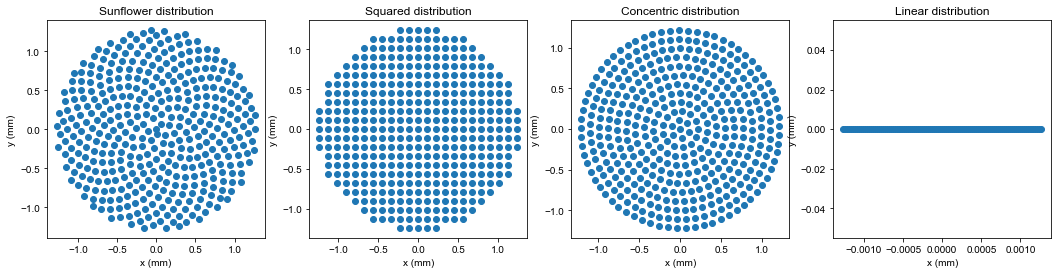

In [3]:
m = 400            # Number of point sources

# Simulate the point sources distributions    
xs, ys = psources[fref].DPSM_sunflowersources(m)    # Sunflower
xq, yq = psources[fref].DPSM_squaredsources(m)      # Squared
xc, yc = psources[fref].DPSM_concentricsources(m)   # Concentric
xl, yl = psources[fref].DPSM_linearsources(m)       # Linear
# Plot the point sources distributions
fig, axes = plt.subplots(1, 4, figsize=(18,4))
ax = axes[0]
ax.set_title('Sunflower distribution')
ax.plot(xs * 1e3, ys * 1e3,'o')
ax = axes[1]
ax.set_title('Squared distribution')
ax.plot(xq * 1e3, yq * 1e3,'o')
ax = axes[2]
ax.set_title('Concentric distribution')
ax.plot(xc * 1e3, yc * 1e3,'o')
ax = axes[3]
ax.set_title('Linear distribution')
ax.plot(xl,yl,'o')
for ax in axes:
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')

# Simulate the US amplitude along normal axis
n = 400   # Number of samples in x, z
x = np.linspace(-0.005, 0.005, n)  # m
z = np.linspace(0, 0.015, n)  # m

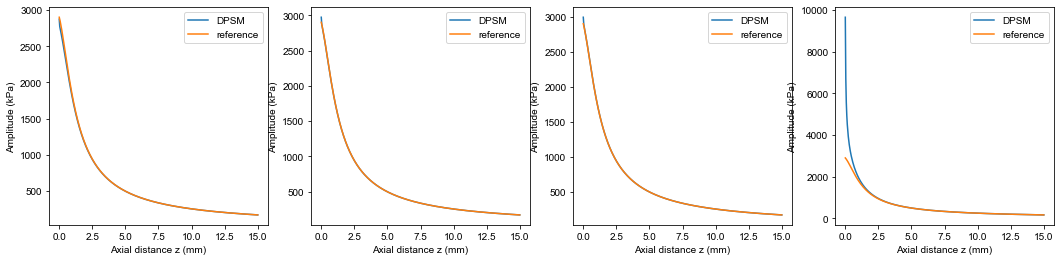

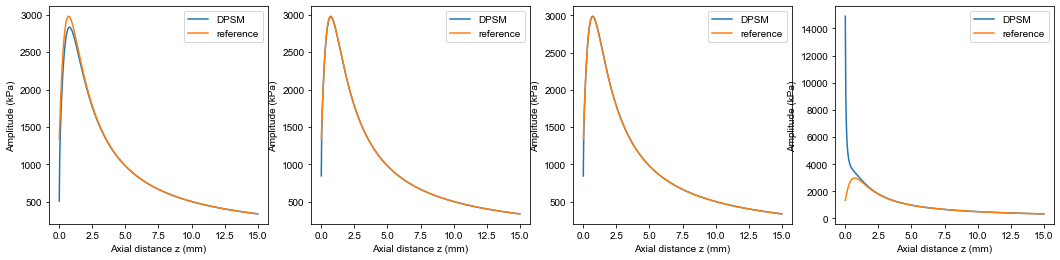

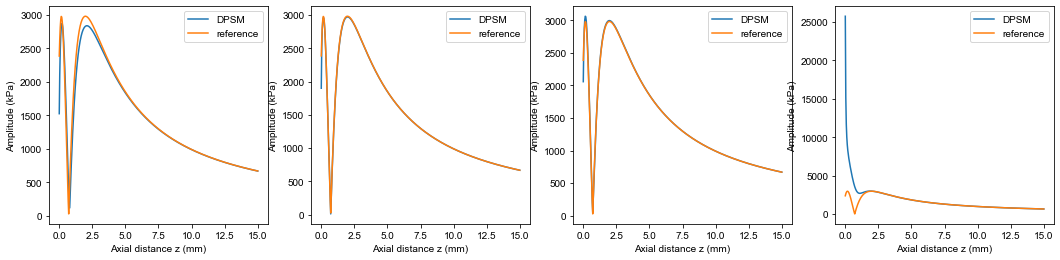

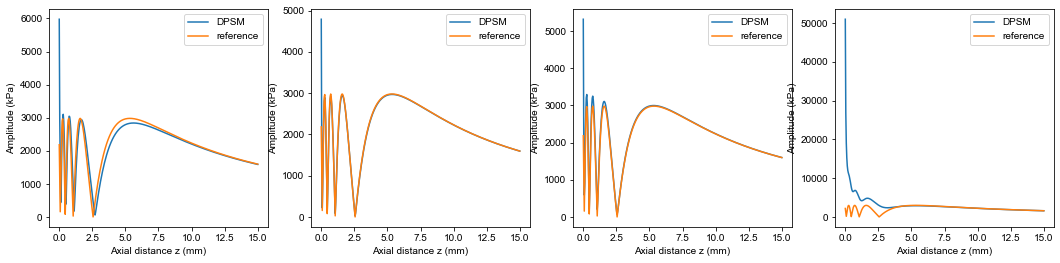

In [4]:
for freq, psource in psources.items():
    
    refamps = psource.normalAxisAmp (z, u_z)
    
    samps = psource.DPSM (x, z, u_z, m, 'sunflower')
    qamps = psource.DPSM (x, z, u_z, m, 'squared')
    camps = psource.DPSM (x, z, u_z, m, 'concentric')
    lamps = psource.DPSM (x, z, u_z, m, 'linear')
    
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    ax = axes[0]
    ax.plot(z * 1e3, samps[int(x.size / 2), :] * 1e-3, label='DPSM')
    ax.plot(z * 1e3, refamps * 1e-3, label='reference')
    ax = axes[1]
    ax.plot(z * 1e3, qamps[int(x.size / 2), :] * 1e-3, label='DPSM')
    ax.plot(z * 1e3, refamps * 1e-3, label='reference')
    ax = axes[2]
    ax.plot(z * 1e3, camps[int(x.size / 2), :] * 1e-3, label='DPSM')
    ax.plot(z * 1e3, refamps * 1e-3, label='reference')
    ax = axes[3]
    ax.plot(z * 1e3, lamps[int(x.size / 2), :] * 1e-3, label='DPSM')
    ax.plot(z * 1e3, refamps * 1e-3, label='reference')
    for ax in axes:
        ax.set_xlabel('Axial distance z (mm)')
        ax.set_ylabel('Amplitude (kPa)')
        ax.legend()

From the figures above we can conclude that:
- At higher frequencies there are some near-field effects.


- The mismatches in the estimation of the acoustic pressure of the circular distributions is mostly in the field near the transducer (low z), at high z the DPSM approximation converges in the analitical solution


- The sunflower distribution seems to be the worst one among the circular distributions


- The linear distribution has strange results, mostly in the near field. Tis means that the circular symmetry is fundamental.

### Comparison of different point sources distributions

Compare the resulting acoustic fields along the z direction (the only one for which we have an analitical solution) varying the number of point sources and the frequency of stimulation.
To do that we have to define a cost function: square root of the mean squared error.

In [9]:
# Definition  of the cost function
# Square root of the mean squared error from the reference amplitude (along z)
def sd (x, z, amps, refamps):
    return np.sqrt( sum((amps[int(x.size / 2), :] - refamps)**2) / (len(z))) 

# Calculation of the cost function of the 3 point sources distributions for different m-f combination
mmin = 100
mmax = 1900
mvalues = 10
mtest = np.linspace(mmin, mmax, mvalues)
sds = np.zeros((mvalues, len(freqs)))
sdq = np.zeros((mvalues, len(freqs)))
sdc = np.zeros((mvalues, len(freqs)))
for j, freq in enumerate(freqs):
    refamps = psources[freq].normalAxisAmp (z, u_z)
    for i, m in enumerate(mtest):
        samps = psources[freq].DPSM (x, z, u_z, m, 'sunflower')
        qamps = psources[freq].DPSM (x, z, u_z, m, 'squared')
        camps = psources[freq].DPSM (x, z, u_z, m, 'concentric')
        sds[i, j] = sd (x, z, samps, refamps)
        sdq[i, j] = sd (x, z, qamps, refamps)
        sdc[i, j] = sd (x, z, camps, refamps)
print('end')

end


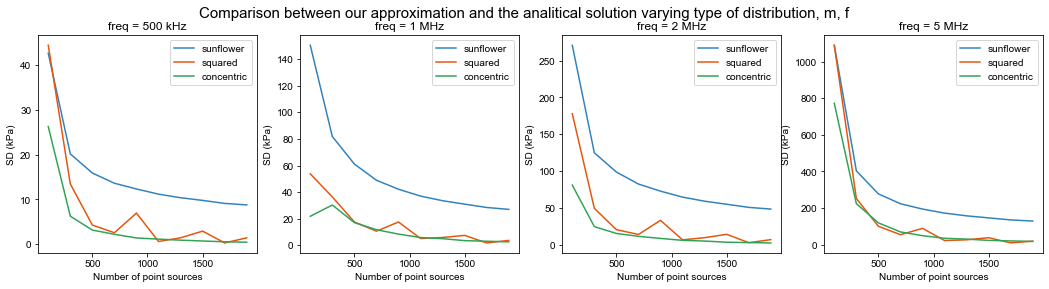

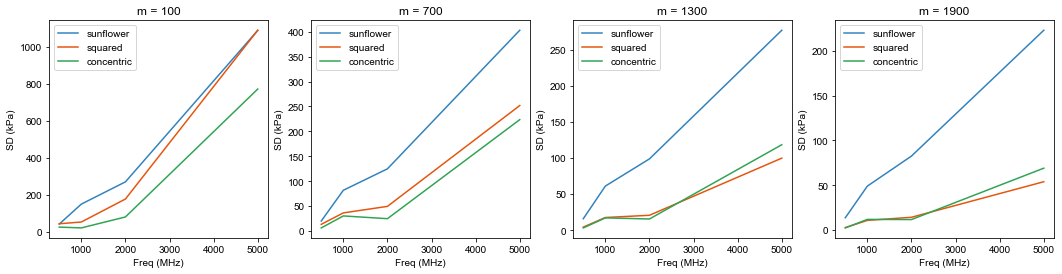

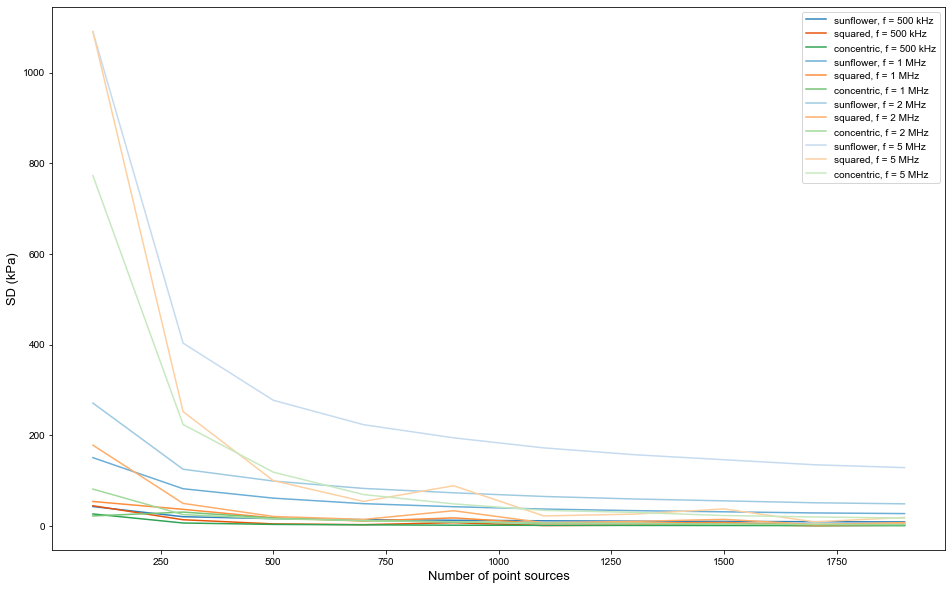

In [10]:
colors = plt.get_cmap('tab20c').colors

def test_sdm(freqs, mtest, sds, sdq, sdc):
    fig, axes = plt.subplots(1, len(freqs), figsize=(18, 4))
    for j, f in enumerate(freqs):
        ax = axes[j]
        ax.set_title(f'freq = {si_format(freqs[j])}Hz') 
        ax.plot(mtest, sds[:,j] * 1e-3, label='sunflower', color=colors[0])
        ax.plot(mtest, sdq[:,j] * 1e-3, label='squared', color=colors[4])
        ax.plot(mtest, sdc[:,j] * 1e-3, label='concentric', color=colors[8])
        ax.set_xlabel('Number of point sources')
        ax.set_ylabel('SD (kPa)')
        ax.legend()
    fig.suptitle('Comparison between our approximation and the analitical solution varying type of distribution, m, f', fontsize=15)
    return fig

def test_sdf(freqs, mvector, sds, sdq, sdc):
    fig, axes = plt.subplots(1, len(mvector), figsize=(18, 4))
    f = np.array(freqs) * 1e-3
    for i, m in enumerate(mvector):
        ax = axes[i]
        ax.set_title(f'm = {mvector[i]:.0f}') 
        ax.plot(f, sds[i,:] * 1e-3, label='sunflower', color=colors[0])
        ax.plot(f, sdq[i,:] * 1e-3, label='squared', color=colors[4])
        ax.plot(f, sdc[i,:] * 1e-3, label='concentric', color=colors[8])
        ax.set_xlabel('Freq (MHz)')
        ax.set_ylabel('SD (kPa)')
        ax.legend()
    return fig

def plot_mf(mvector, freqs, sds, sdq, sdc):
    plt.figure(figsize=(16,10))
    for j, f in enumerate(freqs):
        plt.plot(mtest, sds[:,j] * 1e-3, label=f'sunflower, f = {si_format(f)}Hz', color=colors[j])
        plt.plot(mtest, sdq[:,j] * 1e-3, label=f'squared, f = {si_format(f)}Hz', color=colors[4+j])
        plt.plot(mtest, sdc[:,j] * 1e-3, label=f'concentric, f = {si_format(f)}Hz', color=colors[8+j])
    plt.legend()
    plt.xlabel('Number of point sources', size=13)
    plt.ylabel('SD (kPa)', size=13)
    return fig
    
fig = test_sdm(freqs, mtest, sds, sdq, sdc)
mvector = [mtest[0], mtest[3], mtest[6], mtest[9]]
fig = test_sdf(freqs, mvector, sds, sdq, sdc)
fig = plot_mf(mvector, freqs, sds, sdq, sdc)

From the figures above we can conclude that: 
- The best point sources distribution seems to be the concentric one, given the lower error and the smoothness of the curve. 

The squared distribution has good performance too and the same convergence value, but it is more discountinuous.

The sunflower distribution has the worst performance for each frequency and each number of point sources, and show an higher convergence value comparing to the other two distributions. This may be due to the non-uniformity that we see in the centre of the spatial distribution and this hypothesis agrees with the observation that the mismatch with the analitical solution is higher for low z values. 

- The number of point sources at which we reach the convergence for all the distributions is approximately 1500. From now on we are going to use this value for our model.


- Increasing the frequency increase also the error. This is not a problem because the frequency of our application is 500 kHz.

### 2D acoustic field

Let's compute the 2D acoustic pressure distribution generated by the transducer:

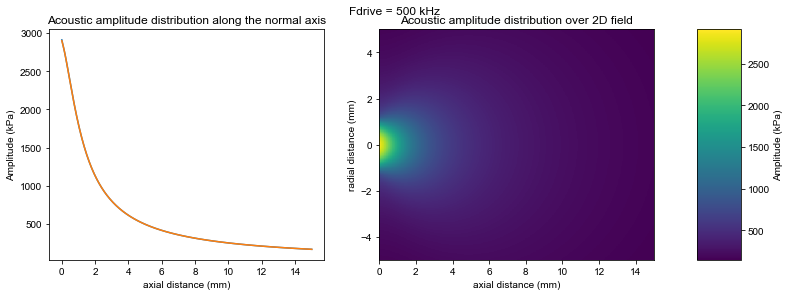

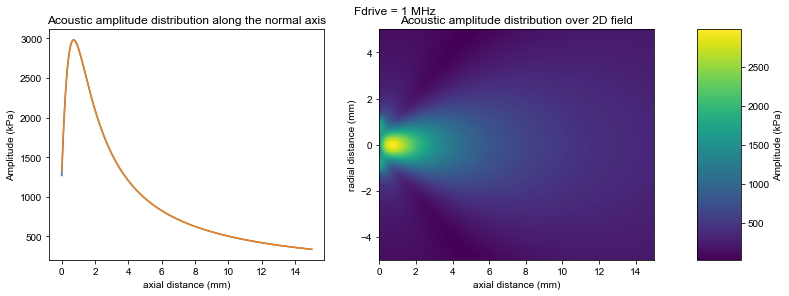

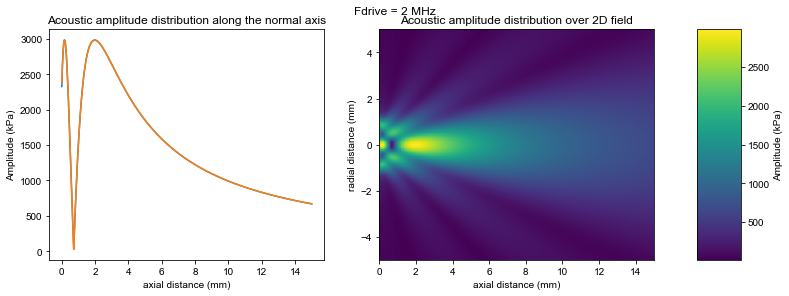

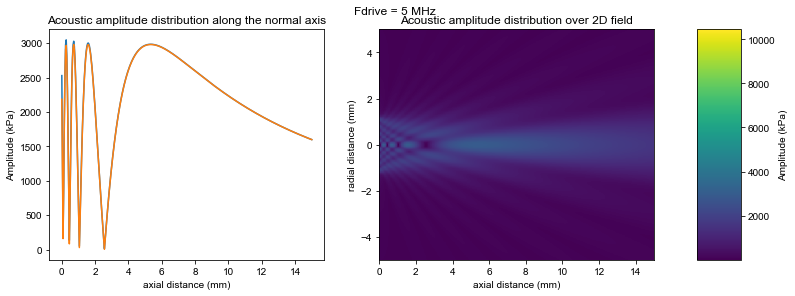

In [8]:
def plotAmpDist(x, z, amps, refamps):
    # Plot amplitude distribution along normal axis and over 2D field
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.80)
    ax = axes[0]
    ax.set_title('Acoustic amplitude distribution along the normal axis')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('Amplitude (kPa)')
    ax.plot(z * 1e3, amps[int(x.size / 2), :] * 1e-3)
    ax.plot(z * 1e3, refamps * 1e-3)
    ax = axes[1]
    ax.set_title('Acoustic amplitude distribution over 2D field')
    ax.set_xlabel('axial distance (mm)')
    ax.set_ylabel('radial distance (mm)')
    sm = ax.pcolormesh(z * 1e3, x * 1e3, amps * 1e-3, cmap='viridis')
    cbarax = fig.add_axes([0.85, 0.10, 0.05, 0.80])
    fig.colorbar(sm, cax=cbarax)
    cbarax.set_ylabel('Amplitude (kPa)')
    return fig

# Generate 2D square grid
n = 400
x = np.linspace(-0.005, 0.005, n)  # m
z = np.linspace(0, 0.015, n)  # m
xx, zz = np.meshgrid(x, z)

m = 1500   # number of point sources at which we reach convergence

# Plot acoustic amplitudes over 2D grid for each frequency
for Fdrive in freqs:
    amps = psources[Fdrive].DPSM (x, z, u_z, m, 'concentric')  # Pa
    refamps = psources[Fdrive].normalAxisAmp (z, u_z)
    fig = plotAmpDist(x, z, amps, refamps)
    fig.suptitle(f'Fdrive = {si_format(Fdrive)}Hz', fontsize=12)

For higher frequencies:
- Higher directionality 


- Higher near-field effect

### Acoustic distribution along fiber

Let's check the resulting acoustic pressure distribution at different distances from the transducer. 

This can be useful to visualise the pressure that affect a fiber placed orthogonally to the acoustic propagation axis.

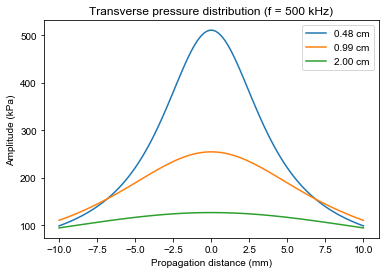

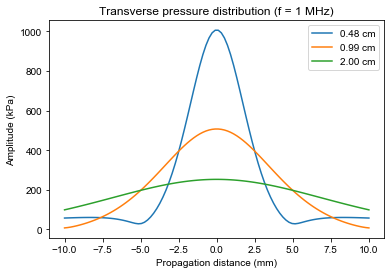

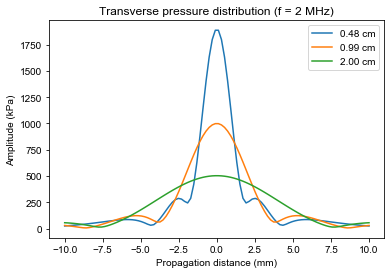

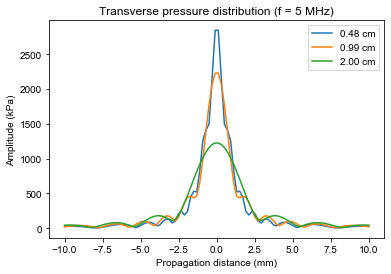

In [8]:
def plotTransverseAmpDist(Fdrive, x, z, amps, index):
    fig, ax = plt.subplots()
    ax.set_title(f'Transverse pressure distribution (f = {si_format(Fdrive)}Hz)')
    ax.set_xlabel('Propagation distance (mm)')
    ax.set_ylabel('Amplitude (kPa)')
    for i in range(len(index)):
        lbl = f'{(z[index[i]] * 1e2):.2f} cm'
        ax.plot(x * 1e3, amps[:,index[i]] * 1e-3, c=f'C{i}', label=lbl)
    ax.legend()
    return fig

m = 1500
n = 100
x = np.linspace(-1e-2, 1e-2, n)
z = np.linspace(0, 0.02, n)  # m
index = [25, 50, 99]
for Fdrive in freqs:
    amps = psources[Fdrive].DPSM(x, z, u_z, m, 'concentric')  # Pa
    plotTransverseAmpDist(Fdrive, x, z, amps, index)

Higher frequency means higher peak pressure amplitude and more selective field. 

## Conclusions
We obtain the 2D ultrasound propagation for a planar circular transducer in a homogeneous medium validated on the Yanagita et al. 2009 paper results.

## References
- Yanagita T., Kundu T., Placko D., "Ultrasonic field modeling by distributed point source method for different transducer boundary conditions.", J. Acoust. Soc. Am. 2009 Nov; 126(5):2331-9. doi: 10.1121/1.3203307. https://bit.ly/2kiNwaS


- Cheng J., Lin W., Qin Y., " Extension of the distributed point source method for ultrasonic field modeling", Ultrasonics 2010.

